In [1]:
using Pkg
Pkg.activate("./")
Pkg.develop(path="../../")

  Activating project at `~/research/UheBsm.jl/notebooks/recreate_nhit_v_z`
   Resolving package versions...
  No Changes to `~/research/UheBsm.jl/notebooks/recreate_nhit_v_z/Project.toml`
  No Changes to `~/research/UheBsm.jl/notebooks/recreate_nhit_v_z/Manifest.toml`


In [2]:
using Revise

In [3]:
using UheBsm
using FHist
using JSON
using LinearAlgebra: norm

[ Info: Precompiling UheBsm [7f07962c-941f-45ca-b37d-c5867083d129] (cache misses: include_dependency fsize change (4))


In [4]:
include("../plotting_boilerplate.jl")

In [5]:
# Downloaded from https://zenodo.org/records/14860165
event = JSON.parsefile("/Users/jlazar/Downloads/uhe-event-v1.0/data/event/KM3-230213A_allhits.json")
# From supplementary material paper of https://inspirehep.net/literature/2879193 / https://www.nature.com/articles/s41586-024-08543-1
# Link currently resides at https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-08543-1/MediaObjects/41586_2024_8543_MOESM1_ESM.pdf
cascade_zs = Float64[199, 297, 477]

3-element Vector{Float64}:
 199.0
 297.0
 477.0

## Make the track from input

In [15]:
track = Track(
    [event["reconstructed_track"]["dir_x"], event["reconstructed_track"]["dir_y"], event["reconstructed_track"]["dir_z"]],
    [event["reconstructed_track"]["pos_x"], event["reconstructed_track"]["pos_y"], event["reconstructed_track"]["pos_z"]],
    event["reconstructed_track"]["t"]
)

track_anchors = [track.pos + track.dir * 1000, track.pos]

2-element Vector{Vector{Float64}}:
 [741.0292801869056, 597.1321167147437, 268.8274180882149]
 [-245.44099312085697, 433.5680178896781, 279.9263124319042]

## Load up all the hits into a hashmap

In [7]:
hitmap = Dict{Tuple{Int, Int, Int}, Vector{Hit}}()
hits = Hit[]

for hit_desc in event["hits"]
    k = (hit_desc["detection_unit"], hit_desc["floor"], hit_desc["channel_id"])
    if k ∉ keys(hitmap)
        hitmap[k] = Hit[]
    end
    hit = Hit(hit_desc)
    push!(hitmap[k], hit)
    push!(hits, hit)
end

for hits in values(hitmap)
    sort!(hits, by=hit->hit.t)
end

first_hits = Hit[first(hits) for hits in values(hitmap)]
big_hits = filter(hit->hit.tot > 32, hits)
big_first_hits = filter(hit->hit.tot > 32, first_hits)

1757-element Vector{Hit}:
 Hit([103.94164938448063, 461.8071685639014, 209.08281154079813], 166.34299999848008, 255.0)
 Hit([105.80866821840944, 465.26103972189327, 357.0396756103254], 209.3149999976158, 255.0)
 Hit([-90.98164872267805, 489.69619193142637, 318.0413021066704], -542.4400000013411, 255.0)
 Hit([105.0507454182269, 463.7705738990873, 282.5785285822899], 27.1739999987185, 255.0)
 Hit([16.673284143287894, 491.44096346691913, 358.5051264058114], -77.35600000247359, 255.0)
 Hit([244.38302366676902, 473.3480538424019, 283.11029887686914], 554.312999997288, 255.0)
 Hit([243.04344999470638, 471.20096617424116, 209.65958248617386], 640.6940000019968, 53.0)
 Hit([-29.05368608809632, 569.4496473228787, 208.58729933926534], -69.22200000286102, 66.0)
 Hit([105.51260871815775, 464.35483104073467, 320.0524383218255], 101.5679999999702, 255.0)
 Hit([16.92295722452199, 492.62499125447283, 394.70797088767665], 43.13699999824166, 197.0)
 Hit([-52.24207560030593, 422.80340979031917, 391.64814

## Take a look at the residual distribution

### First unweighted

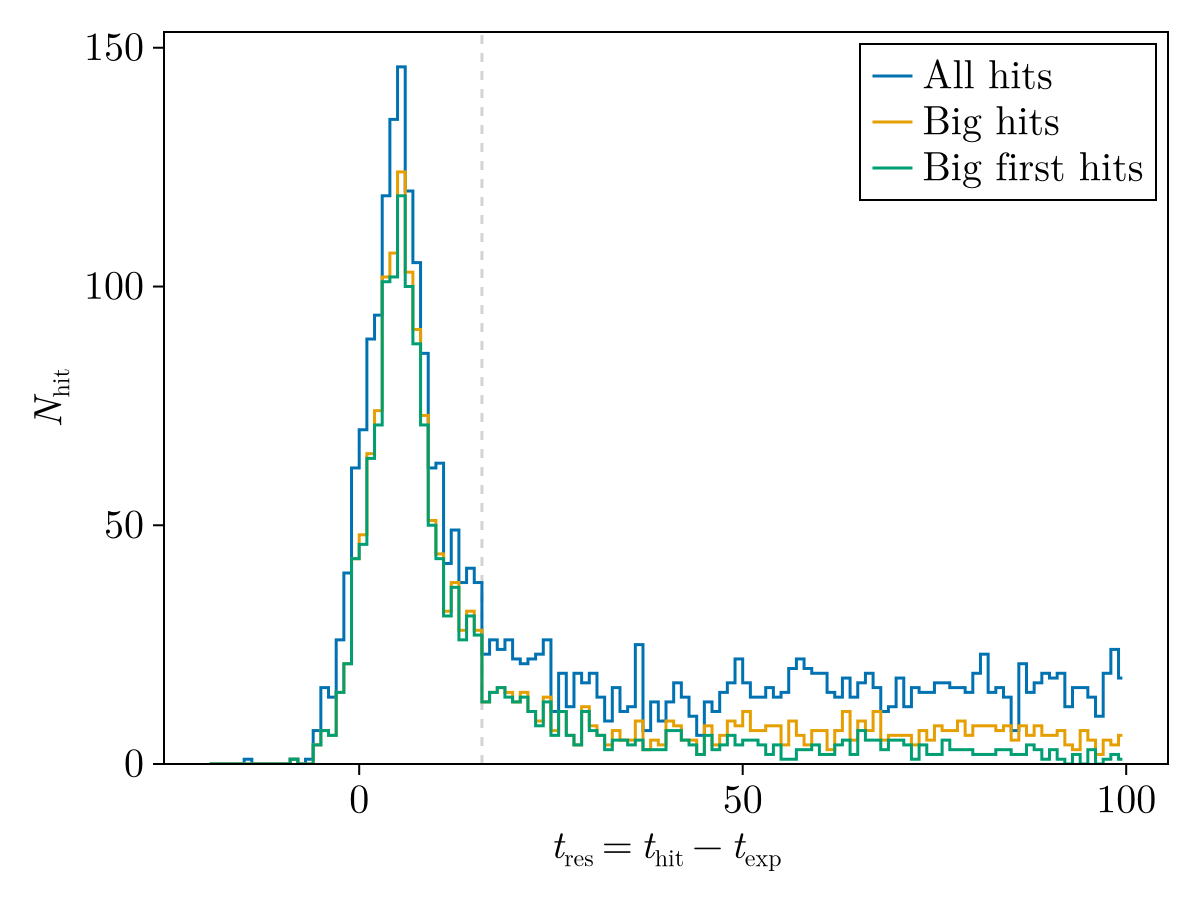

In [8]:
bins = -20:1:100
cents = (bins[2:end] .+ bins[1:end-1]) ./ 2

fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel=res_string,
    ylabel=nhit_string  
)

ylims!(0, nothing)

vlines!(ax, [16], color=:lightgrey, linestyle=:dash)

labels = ["All hits", "Big hits", "Big first hits"]

for (idx, hs) in enumerate([hits, big_hits, big_first_hits])
    h = Hist1D(residual.(hs, Ref(track)), binedges=bins)
    s = stairs!(ax, cents, h.bincounts, step=:center, label=labels[idx])
end

axislegend(ax)

fig

### Then weighted by ToT

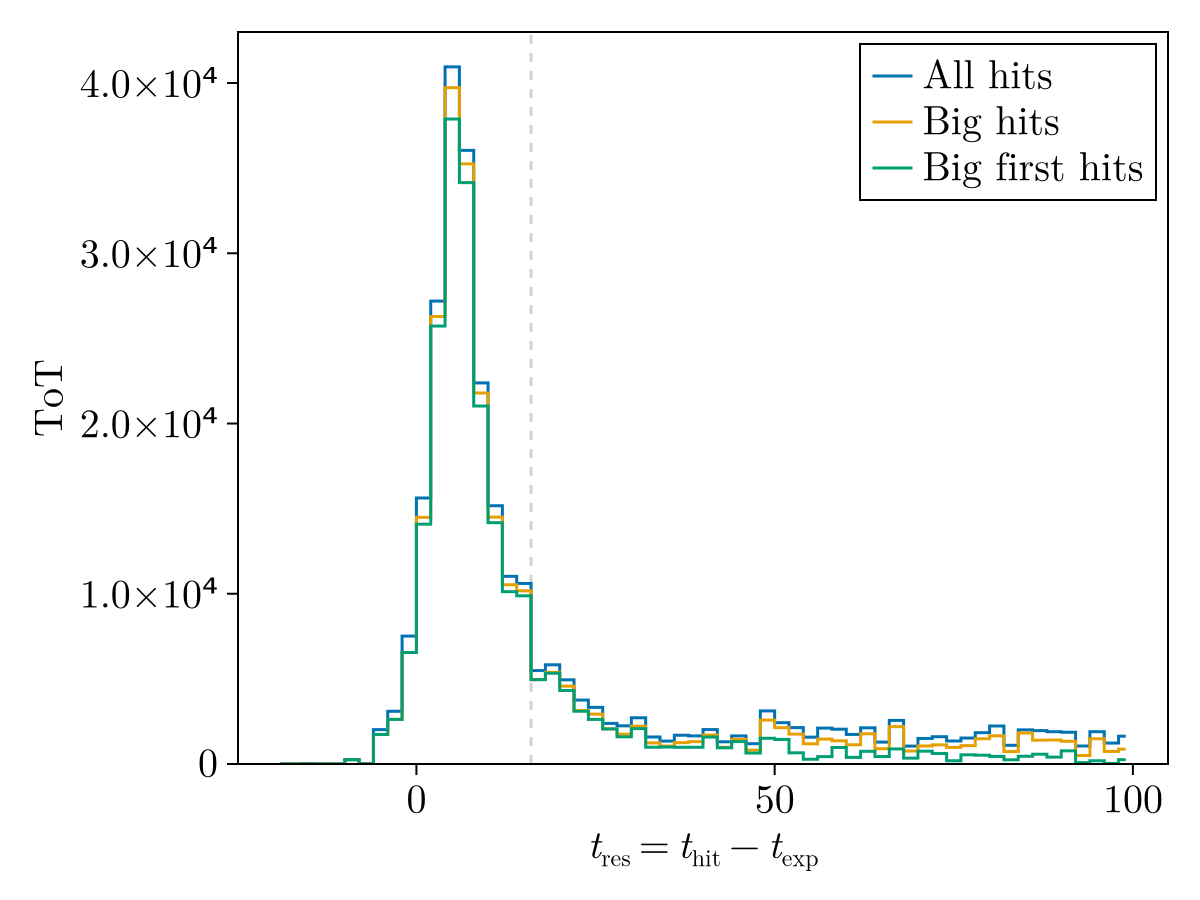

In [9]:
bins = -20:2:100
cents = (bins[2:end] .+ bins[1:end-1]) ./ 2

fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel=res_string,
    ylabel=tot_string  
)

ylims!(0, nothing)

vlines!(ax, [16], color=:lightgrey, linestyle=:dash)

labels = ["All hits", "Big hits", "Big first hits"]

for (idx, hs) in enumerate([hits, big_hits, big_first_hits])
    wgts = Weights(map(hit->hit.tot, hs))
    h = Hist1D(residual.(hs, Ref(track)), binedges=bins, weights=wgts)
    s = stairs!(ax, cents, h.bincounts, step=:center, label=labels[idx])
end

axislegend(ax)

fig

In [10]:
function stairpts(s)
    pts = s.plots[1].converted[1][]
    [p[1] for p in pts], [p[2] for p in pts]
end

stairpts (generic function with 1 method)

## Let's now take a stab at remaking the $N_{\mathrm{hit}}$ vs. $z$ plot

This is for all hits, regardless of their time over threshold

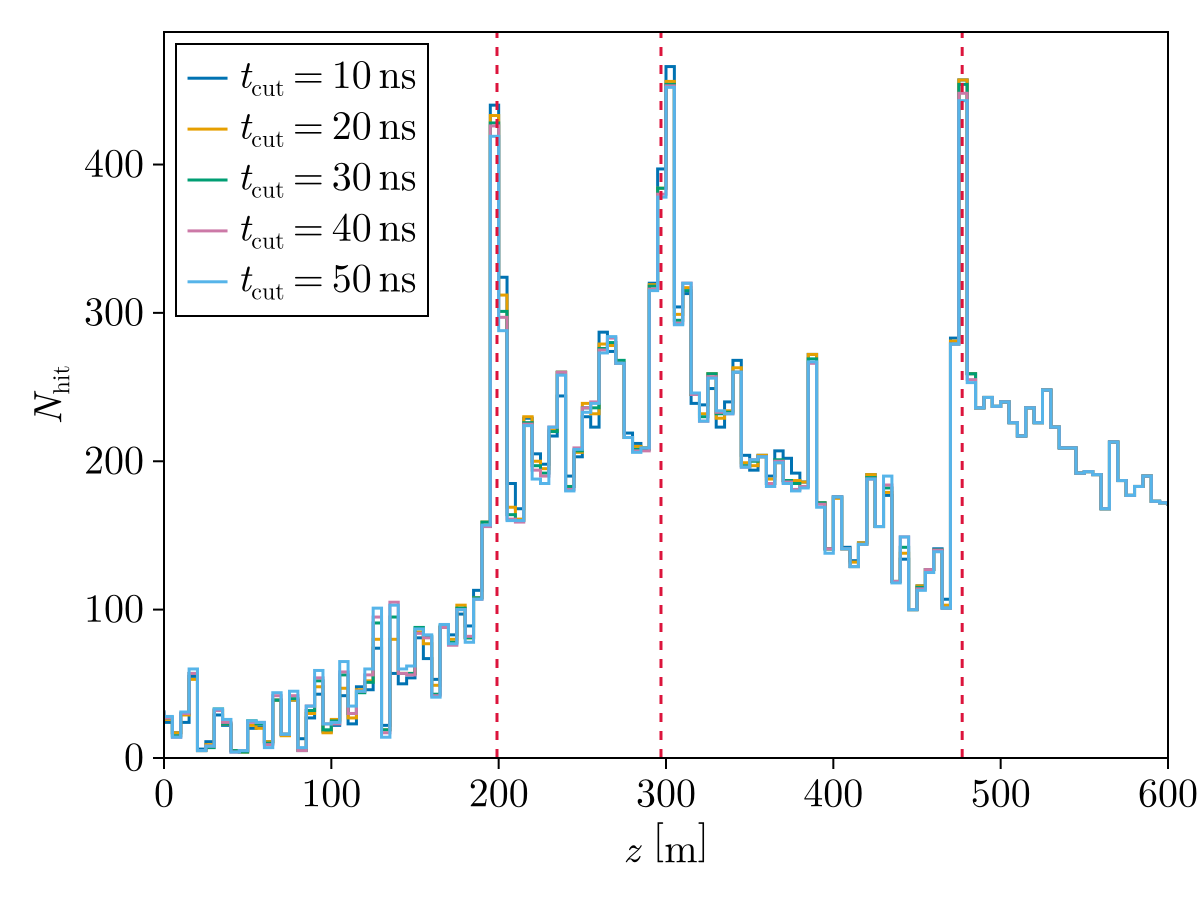

In [41]:
fig = Figure(fontsize=20)
ax = Axis(
    fig[1,1],
    xlabel=L"z~\left[\mathrm{m}\right]",
    ylabel=L"N_{\mathrm{hit}}"
)

xlims!(ax, -0, 600)
ylims!(ax, 0, nothing)

for tcut in [10, 20, 30, 40, 50]

    distances = Float64[]
    tots = Float64[]

    for hits in values(hitmap)
        hits = copy(hits)
#         hits = filter(hit->hit.tot > 32, hits)
        ts = map(hit->residual(hit, track), hits)
        m = ts .<= tcut
        ds = zeros(length(hits))
        ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
        ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
        distances = vcat(distances, ds)
        tots = vcat(tots, map(hit->hit.tot, hits))
    end

    bins = -600:5:1000
#     wgts = Weights(ones(length(distances)))
    h = Hist1D(distances, binedges=bins) 

    cents = (h.binedges[1][1:end-1] + h.binedges[1][2:end]) ./ 2
    widths = h.binedges[1][2:end] .- h.binedges[1][1:end-1]

    stairs!(ax, cents, h.bincounts, step=:center, label=L"t_{\mathrm{cut}}=%$(tcut)\,\mathrm{ns}")
end
    
vlines!(ax, cascade_zs, color=:crimson, linestyle=:dash)

axislegend(ax,  position=:lt)
    
fig

The agreement isn't terrible, but it definitely isn't exact. 
Maybe I need to go back and read the supplemental material a bit more closely.

### Now, we can try to break it down by tracks and cascade contribution

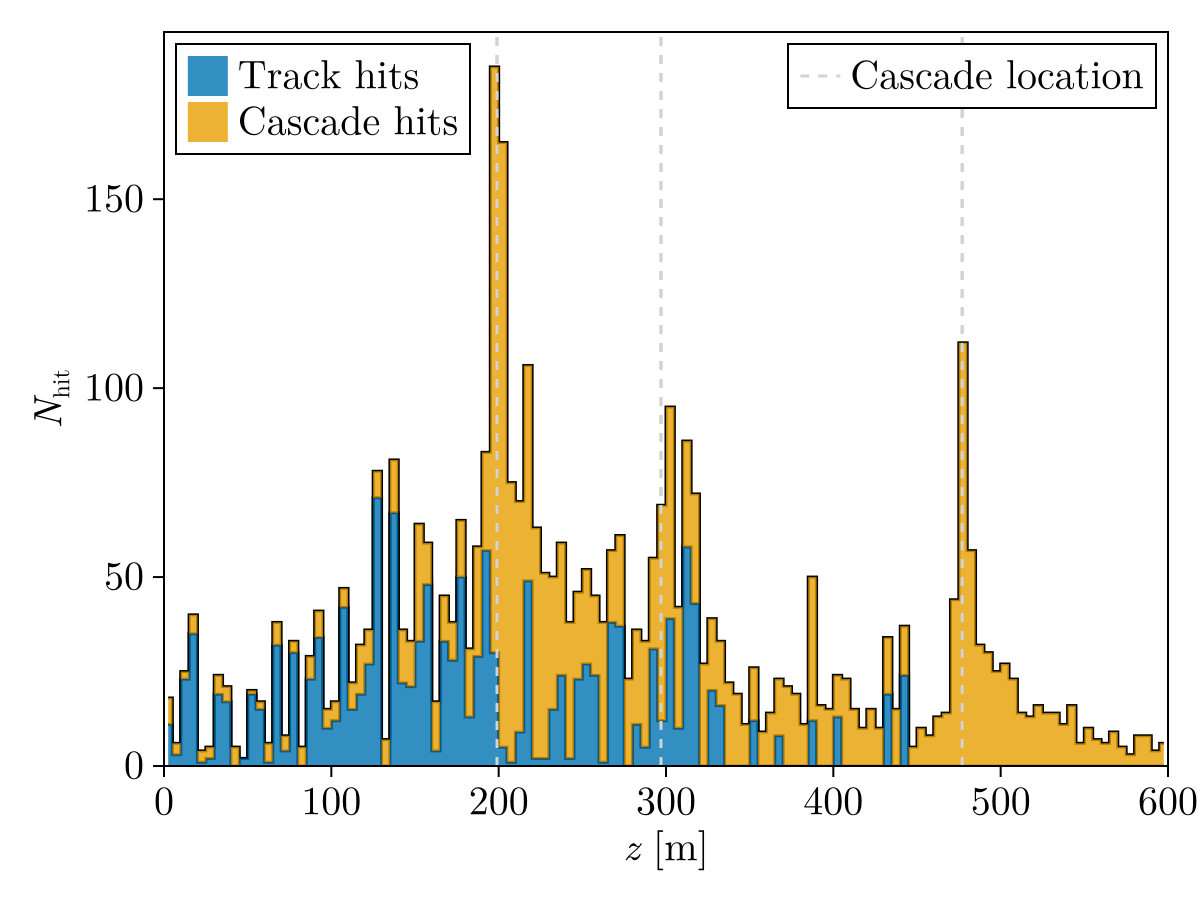

In [22]:
hits = first_hits

residuals = residual.(hits, Ref(track))
m = residuals .< 30

track_hits = hits[m]
cascade_hits = hits[.~m]

cascade_ds = cascade_distance.(cascade_hits, Ref(track))
track_ds = track_distance.(track_hits, Ref(track))
ds = zeros(length(hits))
ds[m] .= track_ds
ds[.~m] .= cascade_ds

bins = 0:5:600
cents = (bins[1:end-1] .+ bins[2:end]) ./ 2
h = Hist1D(ds, binedges=bins)
hcascade = Hist1D(cascade_ds, binedges=bins)
htrack = Hist1D(track_ds, binedges=bins)


fig = Figure()
ax = Axis(
    fig[1, 1],
    limits=(bins[1], bins[end], 0, nothing),
    xlabel=L"z~[\mathrm{m}]",
    ylabel=L"N_{\mathrm{hit}}"
)

vl = vlines!(ax, cascade_zs, color=:lightgrey, linestyle=:dash)
s1 = stairs!(ax, cents, htrack.bincounts, step=:center, visible=true, color=:black)
s2 = stairs!(ax, cents, hcascade.bincounts + htrack.bincounts, step=:center, visible=true, color=:black)

xs1, ys1 = stairpts(s1)
xs2, ys2 = stairpts(s2)

b1 = band!(ax, xs1, 0 * ys1, ys1, alpha=1.0)
b2 = band!(ax, xs2, ys1, ys2, alpha=1.0)

vl = vlines!(ax, cascade_zs, color=:lightgrey, linestyle=:dash)

axislegend(ax, [vl], ["Cascade location"], position=:rt)
axislegend(ax, [b1, b2], ["Track hits", "Cascade hits"], position=:lt)

fig

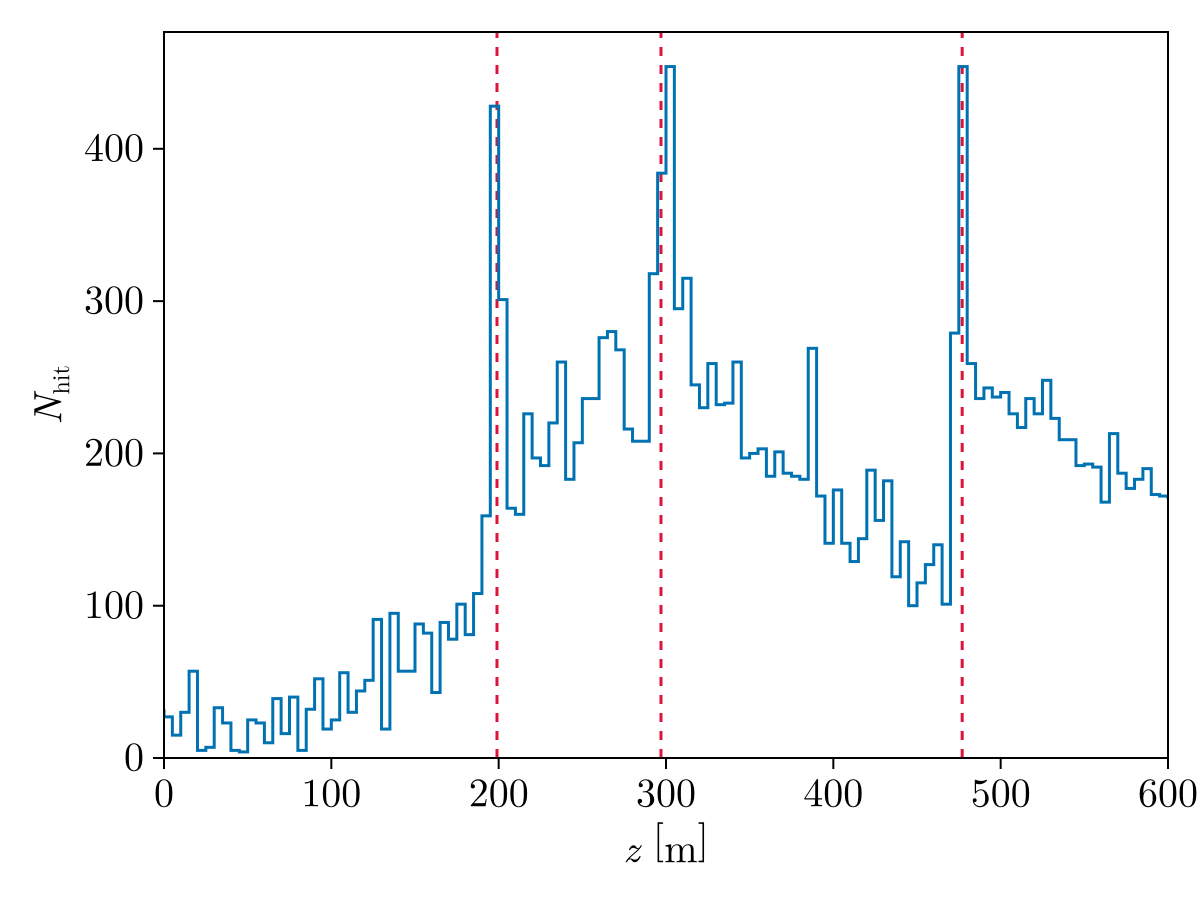

CairoMakie.Screen{IMAGE}


In [61]:
function make_event_display!(ax, om_positions, nhits; cascade_pos=nothing, track_anchors=nothing)
    
    xlims!(ax, -200, 300)
    ylims!(ax, 100, 600)
    zlims!(ax, 100, 600)
    
    sct = scatter!(
        ax,
        map(x->x[1], om_positions),
        map(x->x[2], om_positions),
        map(x->x[3], om_positions),
        color=ts,
        colormap=cgrad(:matter, rev=true),
        markersize=nhits ./ 75
    )
    
    if ~isnothing(track_anchors)
        lines!(
            ax,
            map(x->x[1], track_anchors),
            map(x->x[2], track_anchors),
            map(x->x[3], track_anchors),
        )
    end
    
    if ~isnothing(cascade_pos)
        scatter!(
            ax,
            [cascade_pos[1]],
            [cascade_pos[2]],
            [cascade_pos[3]],
            marker=:star5,
            markersize=30
        )
    end

    return sct, ax
end

make_event_display! (generic function with 1 method)

In [67]:
function collapse_to_oms(hitmap::Dict{Tuple{Int, Int, Int}, Vector{Hit}})
    new_hitmap = Dict{Tuple{Int, Int}, Vector{Hit}}()
    for (key, hits) in hitmap
        new_key = key[1:2]
        if ~(new_key in keys(new_hitmap))
            new_hitmap[new_key] = Hit[]
        end
        new_hitmap[new_key] = vcat(new_hitmap[new_key], hits)
    end
    return new_hitmap
end

collapse_to_oms (generic function with 1 method)

In [68]:
function collapse(hitmap::Dict{Tuple{Int, Int, Int}, Vector{Hit}})
    flathits = Hit[]
    for hits in values(hitmap)
        flathits = vcat(flathits, hits)
    end
    return flathits
end

collapse (generic function with 1 method)

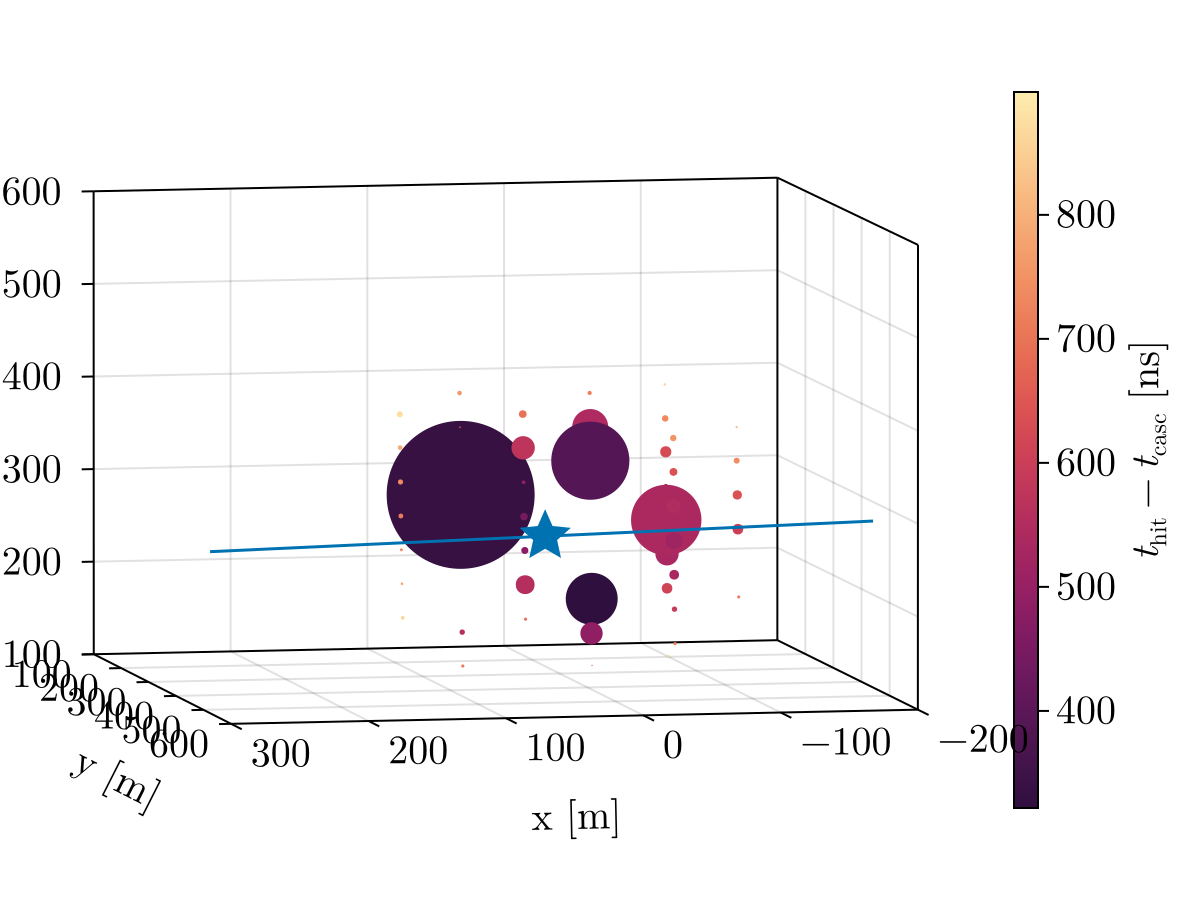

In [64]:
cascade_z = cascade_zs[2]
cascade_t = (track.t + cascade_z / constants.speed_of_light)
cascade_pos = track.pos + track.dir * cascade_z

tot_min = 32
distance_threshold = 5

close_hitmap = typeof(hitmap)()

for (key, hits) in hitmap
    hits = copy(hits)
    # Filter out small hits
    hits = filter(hit->hit.tot>tot_min, hits)
    
    # Filter out hits that originate from far away
    ts = map(hit->residual(hit, track), hits)
    m = ts .<= 30
    ds = zeros(length(hits))
    ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
    ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
    m = abs.(cascade_z .- ds) .<= distance_threshold
    hits = hits[m]
    hits = filter(hit->hit.t >= cascade_t, hits)
    hits = filter(hit->hit.t <= cascade_t + 920, hits)
    
    if length(hits)==0
        continue
    end

    
    close_hitmap[key] = hits
end

close_hitmap = collapse_to_oms(close_hitmap)

nhits = Int[]
positions = Vector{Float64}[]
ts = Float64[]

for hits in values(close_hitmap)
    ahh = map(hit->hit.t - cascade_t, hits)
    idx = argmin(ahh)
#     nhit = length(hits)
    nhit = sum(map(hit->hit.tot, hits))
    pos = first(hits).pos
    push!(positions, pos)
    push!(nhits, nhit)
    push!(ts, ahh[idx])
end

fig = Figure()

ax1 = Axis3(
    fig[1, 1],
    azimuth=π/2-0.2,
    elevation=0.1,
#     elevation=π / 2 - 0.1,
    xlabel="x [m]",
    ylabel="y [m]",
    zlabel="z [m]"
)

sct, ax = make_event_display!(ax1, positions, nhits, cascade_pos=cascade_pos, track_anchors=track_anchors)
    
Colorbar(
    fig[1, 2],
    sct,
    label=L"t_{\mathrm{hit}} - t_{\mathrm{casc}}~[\mathrm{ns}]"
)

fig

In [48]:
# using Statistics: std

In [113]:
cascade_z = cascade_zs[3]
cascade_t = (track.t + cascade_z / constants.speed_of_light)
cascade_pos = track.pos + track.dir * cascade_z

tot_min = 32
distance_threshold = 5

close_hitmap = typeof(hitmap)()

for (key, hits) in hitmap
    hits = copy(hits)
    # Filter out small hits
    hits = filter(hit->hit.tot>tot_min, hits)
    
    # Filter out hits that originate from far away
    ts = map(hit->residual(hit, track), hits)
    m = ts .<= 30
    ds = zeros(length(hits))
    ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
    ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
    m = abs.(cascade_z .- ds) .<= 5
    hits = hits[m]
    hits = filter(hit->hit.t >= cascade_t, hits)
    hits = filter(hit->hit.t <= cascade_t + 920, hits)
    
    if length(hits)==0
        continue
    end

    
    close_hitmap[key] = hits
end

om_hits = collapse_to_oms(hitmap)
distances = Float64[]
for hits in values(om_hits)
    closest_distance = minimum(hit->norm(hit.pos .- cascade_pos), hits)
    push!(distances, closest_distance)
end

edges = 0:15:300
cents = (edges[1:end-1] + edges[2:end]) ./ 2
widths = edges[2:end] - edges[1:end-1]

ds = map(hit->norm(hit.pos .- cascade_pos), collapse(close_hitmap))
wgts = Weights(map(hit->hit.tot, collapse(close_hitmap)))

h1 = Hist1D(ds, weights=wgts, binedges=edges)

h2 = Hist1D(distances, binedges=edges)

edges: [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  165.0, 180.0, 195.0, 210.0, 225.0, 240.0, 255.0, 270.0, 285.0, 300.0]
bin counts: [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 2.0, 7.0, 6.0, 3.0, 5.0, 6.0, 9.0, 11.0, 14.0, 13.0, 12.0, 13.0, 13.0]
total count: 120.0

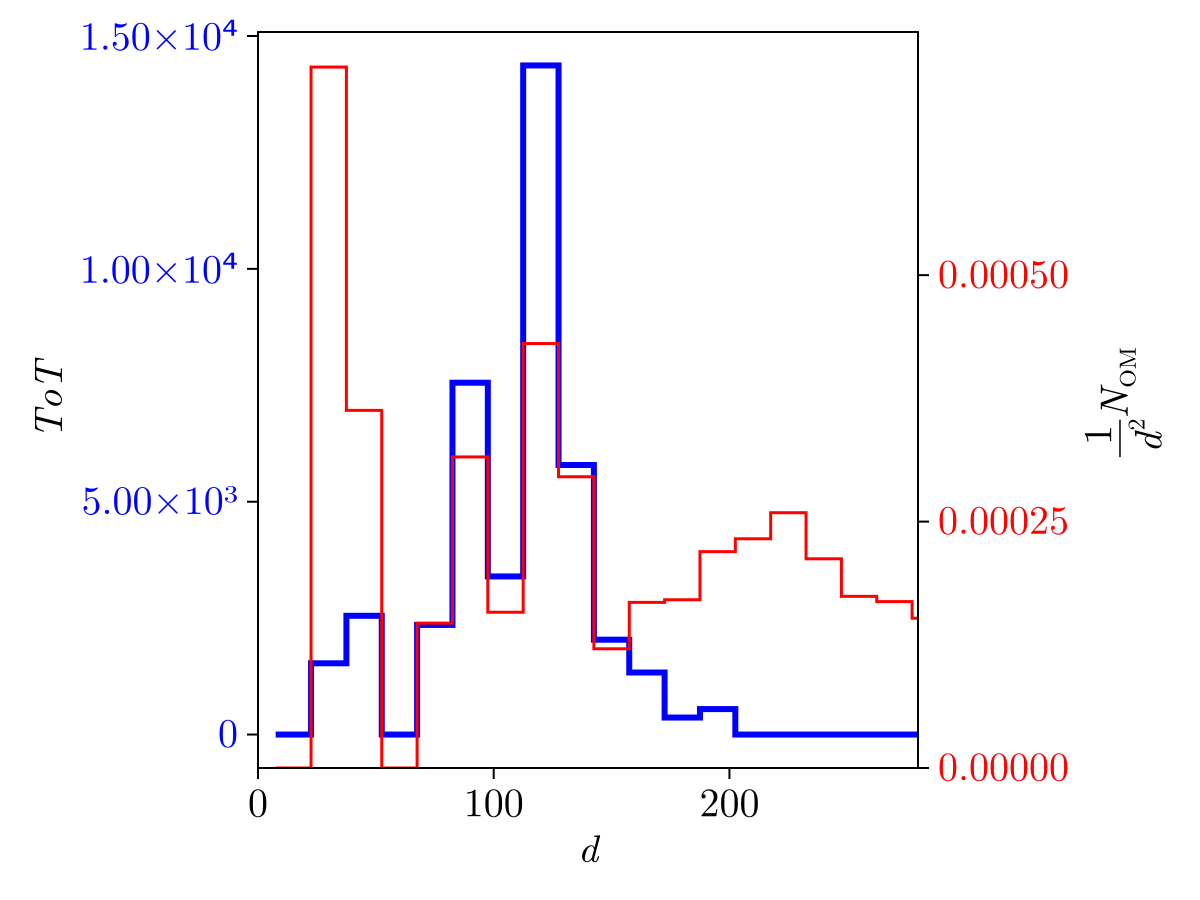

In [114]:
fig = Figure()


ax1 = Axis(
    fig[1, 1],
    yticklabelcolor=:blue,
    xlabel=L"d",
    ylabel=L"ToT"
)

ax2 = Axis(
    fig[1, 1],
    yticklabelcolor=:red,
    yaxisposition=:right,
    ylabel=L"\frac{1}{d^{2}}N_{\mathrm{OM}}"
)

xlims!(ax1, 0, 280)
xlims!(ax2, 0, 280)
ylims!(ax2, 0, nothing)
ylims!(ax2, 0, nothing)

hidespines!(ax2)
hidexdecorations!(ax2)

stairs!(ax1, cents, h1.bincounts, color=:blue, linewidth=3)
stairs!(ax2, cents, h2.bincounts ./ cents.^2, color=:red)

fig

In [ ]:
# cascade_z = cascade_zs[3]
# cascade_t = (track.t + cascade_z / constants.speed_of_light)
# cascade_pos = track.pos + track.dir * cascade_z

# tot_min = 32
# distance_threshold = 5

# close_hitmap = typeof(hitmap)()

# for (key, hits) in hitmap
#     hits = copy(hits)
#     # Filter out small hits
#     hits = filter(hit->hit.tot>tot_min, hits)
    
#     # Filter out hits that originate from far away
#     ts = map(hit->residual(hit, track), hits)
#     m = ts .<= 30
#     ds = zeros(length(hits))
#     ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
#     ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
#     m = abs.(cascade_z .- ds) .<= distance_threshold
    
#     hits = hits[m]
    
#     hits = filter(hit->hit.t >= cascade_t, hits)
#     hits = filter(hit->hit.t <= cascade_t + 920, hits)
    
#     if length(hits)==0
#         continue
#     end

    
#     close_hitmap[key] = hits
# end

# close_hitmap = organize_to_oms(close_hitmap)

# nhits = Int[]
# positions = Vector{Float64}[]
# ts = Float64[]

# for hits in values(close_hitmap)
#     ahh = map(hit->hit.t - cascade_t, hits)
#     idx = argmin(ahh)
#     nhit = sum(map(hit->hit.tot, hits))
#     pos = first(hits).pos
#     push!(positions, pos)
#     push!(nhits, nhit)
#     push!(ts, ahh[idx])
# end

# fig = Figure()

# ax1 = Axis3(
#     fig[1, 1],
#     azimuth=π/2-0.2,
#     elevation=0.1,
# #     elevation=π / 2 - 0.1,
#     xlabel="x [m]",
#     ylabel="y [m]",
#     zlabel="z [m]"
# )

# sct, ax = make_event_display!(ax1, positions, nhits, cascade_pos=cascade_pos, track_anchors=track_anchors)
    
# Colorbar(
#     fig[1, 2],
#     sct,
#     label=L"t_{\mathrm{hit}} - t_{\mathrm{casc}}~[\mathrm{ns}]"
# )

# fig

In [230]:
# close_hits = Hit[]
# cascade_z = cascade_zs[1]
# cascade_t = (track.t + cascade_z / constants.speed_of_light)
# cascade_pos = track.pos + track.dir * cascade_z

# tot_min = 30

# close_hitmap = typeof(hitmap)()

# for (key, hits) in hitmap
#     hits = copy(hits)
#     # Filter out small hits
#     filter!(hit->hit.tot>tot_min, hits)
    
#     # Filter out hits that originate from far away
#     ts = map(hit->residual(hit, track), hits)
#     m = ts .<= 30
#     ds = zeros(length(hits))
#     ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
#     ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
#     m = abs.(cascade_z .- ds) .<= 5
#     close_hits = vcat(close_hits, hits[m])
# #     hits = hits[m]
# #     if length(hits)==0
# #         continue
# #     end
# #     close_hitmap[key] = hits
# end

# # close_hitmap = organize_to_oms(close_hitmap)

# # positions = [first(hits).pos for hits in values(close_hitmap)]
# # nhits = [length(hits) for hits in values(close_hitmap)]
# # ts = [minimum(map(hit->hit.t - cascade_t, hits)) for hits in values(close_hitmap)]

# a = [UheBsm.sort_to_doms(x) for x in UheBsm.sort_to_strings(close_hits)]
# nhits = Int[]
# positions = Vector{Float64}[]
# ts = Float64[]

# for x in a
#     for hits in x
#         ahh = map(hit->hit.t - cascade_t, hits)
# #         filter!(t->0 <= t && t <= cascade_t + 200 / constants.v_group, ahh)
#         if length(ahh)==0
#             continue
#         end
#         idx = argmin(ahh)
#         nhit = hits[idx].tot
#         pos = first(hits).pos
#         push!(positions, pos)
#         push!(nhits, nhit)
#         push!(ts, ahh[idx])
#     end
# end

# fig = Figure()

# ax1 = Axis3(
#     fig[1, 1],
#     azimuth=π/2-0.2,
#     elevation=0.1,
#     xlabel="x [m]",
#     ylabel="y [m]",
#     zlabel="z [m]"
# )

# sct, ax = make_event_display!(ax1, positions, nhits, cascade_pos=cascade_pos, track_positions=track_positions)
    
# Colorbar(fig[1, 2], sct, label=L"t_{\mathrm{hit}} - t_{\mathrm{casc}}~[\mathrm{ns}]")

# fig

In [ ]:
h.

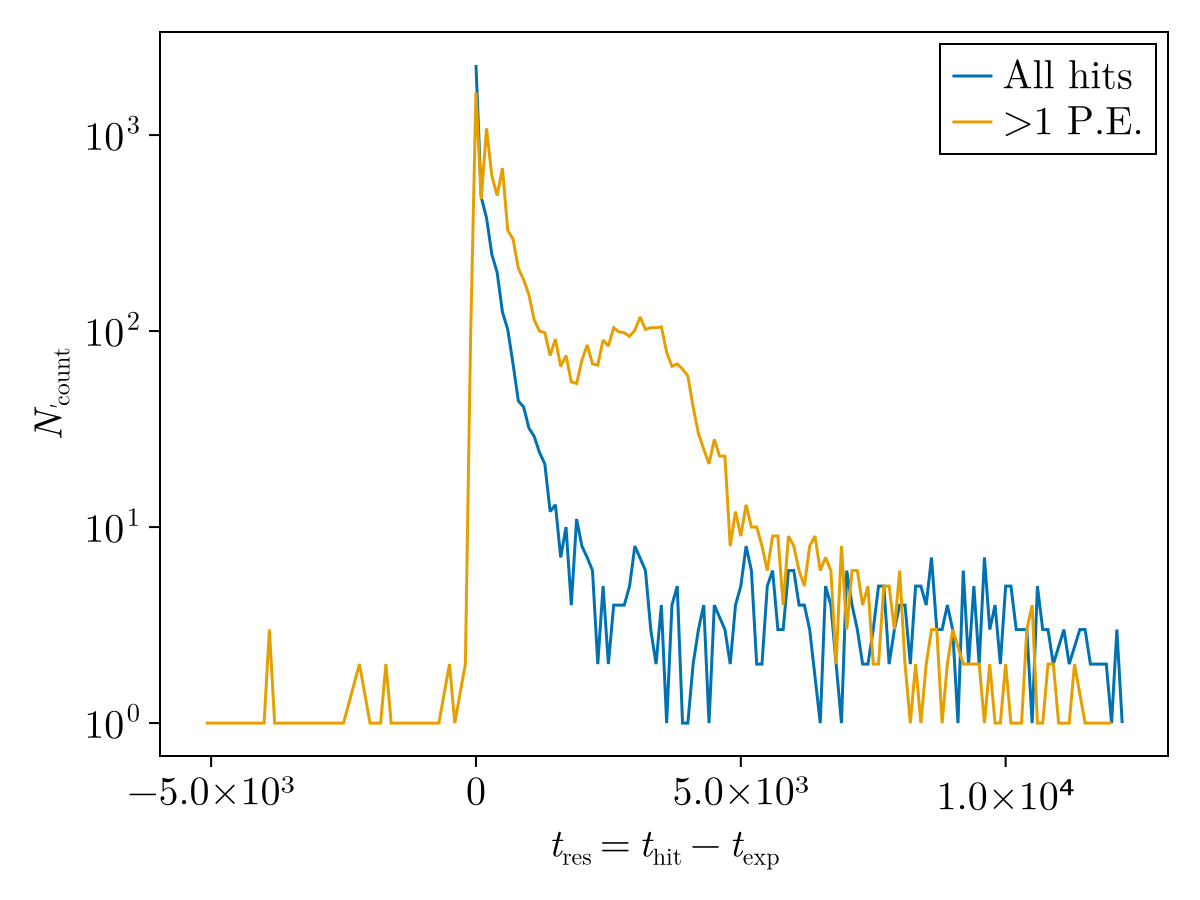

In [90]:
bins = -6000:100:14000
big_h = Hist1D(map(hit->residual(hit, track), big_hits), binedges=bins)
h = Hist1D(map(hit->residual(hit, track), hits), binedges=bins)

fig = Figure()

ax = Axis(
    fig[1, 1],
    yscale=log10,
    xlabel=res_string,
    ylabel=L"N_{'\mathrm{count}}"
)

big_m = big_h.bincounts .> 0
m = h.bincounts .> 0
lines!(ax, bins[1:end-1][m], h.bincounts[m], label="All hits")
lines!(ax, bins[1:end-1][big_m], big_h.bincounts[big_m], label=">1 P.E.")

axislegend(ax)

fig

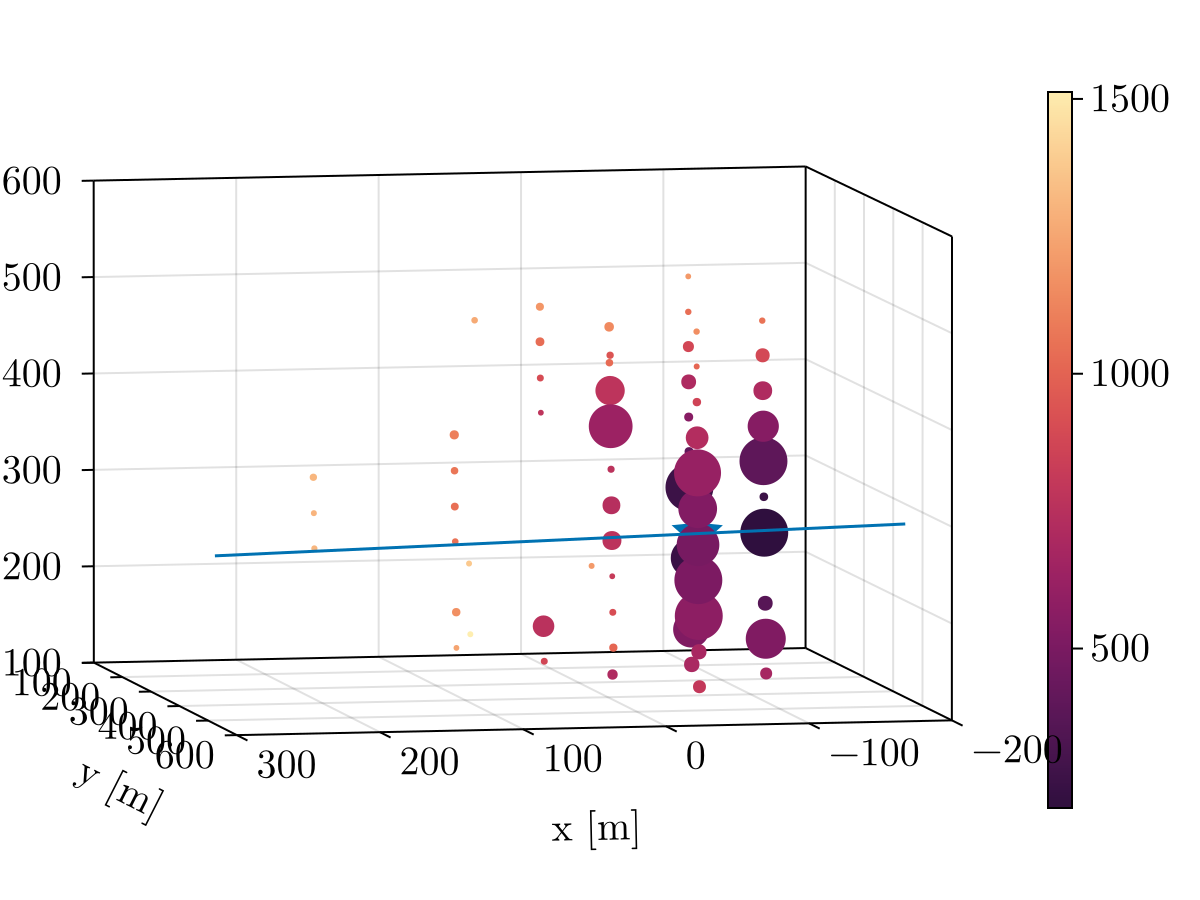

In [119]:
# close_hits = Hit[]
# cascade_z = cascade_zs[1]

# for hits in values(hitmap)
#     hits = copy(hits)
#     hits = filter(hit->hit.tot>30, hits)
#     ts = map(hit->residual(hit, track), hits)
#     m = ts .<= 30
#     ds = zeros(length(hits))
#     ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
#     ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
#     m = abs.(cascade_z .- ds) .<= 5
#     close_hits = vcat(close_hits, hits[m])
# end

# a = [UheBsm.sort_to_doms(x) for x in UheBsm.sort_to_strings(close_hits)]
# nhits = Int[]
# positions = Vector{Float64}[]
# ts = Float64[]

# for x in a
#     for y in x
#         ahh = map(x->x.t, y)
#         if length(ahh)==0
#             continue
#         end
#         filter(t->t < 600 && t > 0, ahh)
#         if length(ahh)==0
#             continue
#         end
#         idx = argmin(ahh)
#         nhit = y[idx].tot
#         pos = first(y).pos
#         push!(positions, pos)
#         push!(nhits, nhit)
#         push!(ts, ahh[idx])
#     end
# end

# ts = ts .- (track.t + cascade_z / constants.speed_of_light)
# cascade_pos = track.pos + track.dir * cascade_z

# fig = Figure()

# ax = Axis3(
#     fig[1, 1],
#     azimuth=π/2-0.2,
#     elevation=0.1,
#     xlabel="x [m]",
#     ylabel="y [m]",
#     zlabel="z [m]"
# )

# xlims!(-200, 300)
# ylims!(100, 600)
# zlims!(100, 600)

# scatter!(
#     ax,
#     [cascade_pos[1]],
#     [cascade_pos[2]],
#     [cascade_pos[3]],
#     marker=:star5,
#     markersize=30
# )

# sct = scatter!(
#     ax,
#     map(x->x[1], positions),
#     map(x->x[2], positions),
#     map(x->x[3], positions),
#     color=ts,
#     colormap=cgrad(:matter, rev=true),
#     markersize=nhits ./ 7.5
# )

# lines!(
#     ax,
#     map(x->x[1], track_positions),
#     map(x->x[2], track_positions),
#     map(x->x[3], track_positions),
# )
    
# Colorbar(fig[1, 2], sct)

# fig

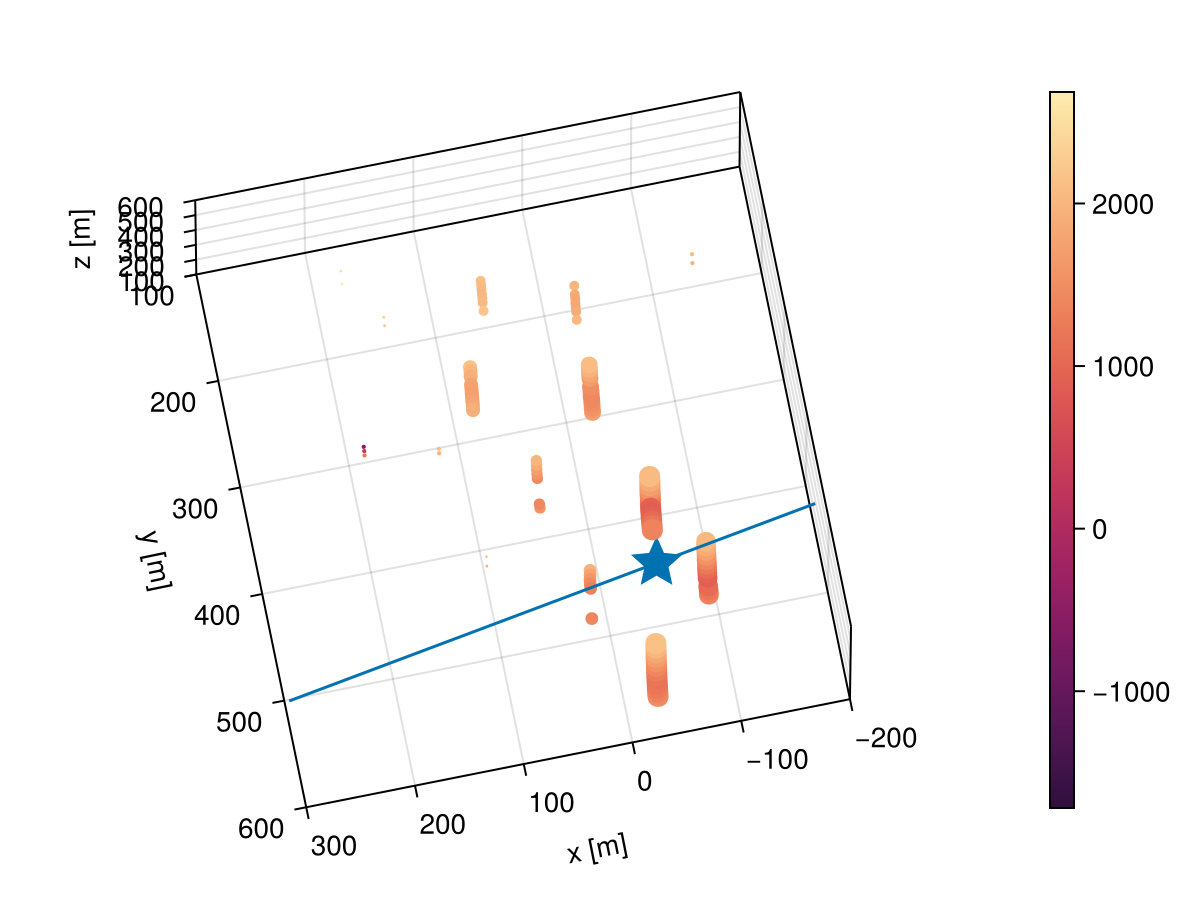

In [109]:
# distances = Float64[]
close_hits = VheBsm.Hit[]
cascade_z = cascade_zs[1]

for hits in values(hit_map)
    hits = copy(hits)
    ts = map(hit->hit.residual_t[track], hits)
    m = ts .<= 30
    ds = zeros(length(hits))
    ds[m] .= map(hit->(hit.emission_t[track] - track.t) * constants.speed_of_light, hits[m])
    ds[.~m] .= map(hit->VheBsm.cascade_distance(hit, track), hits[.~m])
    m = abs.(cascade_z .- ds) .<= 5
    close_hits = vcat(close_hits, hits[m])
end

a = [VheBsm.sort_to_doms(x) for x in VheBsm.sort_to_strings(close_hits)]
nhits = Int[]
positions = Vector{Float64}[]
ts = Float64[]

for x in a
    for y in x
        ahh = map(x->x.t - track.t, y)
        if length(ahh)==0
            continue
        end
        filter(t->t < 600 && t > 0, ahh)
        if length(ahh)==0
            continue
        end
        nhit = length(x)
        pos = first(y).pos
        push!(positions, pos)
        push!(nhits, nhit)
        filter
        push!(ts, minimum(ahh))
    end
end

# ts = ts .- minimum(ts)
cascade_pos = track.pos + track.dir * cascade_z

fig = Figure()

ax = Axis3(
    fig[1, 1],
    azimuth=π/2-0.2,
    elevation=π/2-0.2,
    xlabel="x [m]",
    ylabel="y [m]",
    zlabel="z [m]"
)

xlims!(-200, 300)
ylims!(100, 600)
zlims!(100, 600)

scatter!(
    ax,
    [cascade_pos[1]],
    [cascade_pos[2]],
    [cascade_pos[3]],
    marker=:star5,
    markersize=30
)

sct = scatter!(
    ax,
    map(x->x[1], positions),
    map(x->x[2], positions),
    map(x->x[3], positions),
    color=ts,
    colormap=cgrad(:matter, rev=true),
    markersize=nhits
#     colorrange=(0, 2000)
)

lines!(
    ax,
    map(x->x[1], track_positions),
    map(x->x[2], track_positions),
    map(x->x[3], track_positions),
)
    
Colorbar(fig[1, 2], sct)

fig

In [171]:
min_t = minimum(map(hit->hit.t, hits))
map(hit->hit.t - track.t, hits)

bins = 0:30:4000
Hist1D(
    map(hit->hit.residual_t[track], hits), bins
)

edges: 0:30:3990
bin counts: [1588, 444, 478, 472, 446, 370, 461, 402, 986, 526  …  76, 91, 82, 85, 63, 63, 65, 76, 66, 57]
total count: 24548

## Let's break it down by track and cascade hits

In [112]:
cascade_hits = filter(hit->hit.residual_t[track] > 30, hits)
track_hits = filter(hit->hit.residual_t[track] < 30, hits)
# distances = Float64[]
close_hits = VheBsm.Hit[]
cascade_z = cascade_zs[3]

for hits in values(hit_map)
    hits = copy(hits)
    ts = map(hit->hit.residual_t[track], hits)
    m = ts .<= 30
    ds = zeros(length(hits))
    # TODO use the convenience function you wrote
    ds[m] .= map(hit->(hit.emission_t[track] - track.t) * constants.speed_of_light, hits[m])
    
    ds[.~m] .= map(hit->VheBsm.cascade_distance(hit, track), hits[.~m])
    m = abs.(cascade_z .- ds) .<= 5
    close_hits = vcat(close_hits, hits[m])
end

a = [UheBsm.sort_to_doms(x) for x in UheBsm.sort_to_strings(close_hits)]
nhits = Int[]
positions = Vector{Float64}[]
ts = Float64[]

for x in a
    for y in x
        ahh = map(x->x.t, y)
        if length(ahh)==0
            continue
        end
        filter(t->t < 600 && t > 0, ahh)
        if length(ahh)==0
            continue
        end
        idx = argmin(ahh)
        nhit = y[idx].tot
#         nhit = length(x)
        pos = first(y).pos
        push!(positions, pos)
        push!(nhits, nhit)
        push!(ts, ahh[idx])
    end
end

ts = ts .- (track.t + cascade_z / constants.speed_of_light)
cascade_pos = track.pos + track.dir * cascade_z

fig = Figure()

ax = Axis3(
    fig[1, 1],
    azimuth=π/2-0.2,
    elevation=0.1,
    xlabel="x [m]",
    ylabel="y [m]",
    zlabel="z [m]"
)

xlims!(-200, 300)
ylims!(100, 600)
zlims!(100, 600)

scatter!(
    ax,
    [cascade_pos[1]],
    [cascade_pos[2]],
    [cascade_pos[3]],
    marker=:star5,
    markersize=30
)

sct = scatter!(
    ax,
    map(x->x[1], positions),
    map(x->x[2], positions),
    map(x->x[3], positions),
    color=ts,
    colormap=cgrad(:matter, rev=true),
    markersize=nhits ./ 7.5
#     colorrange=(0, 2000)
)

lines!(
    ax,
    map(x->x[1], track_positions),
    map(x->x[2], track_positions),
    map(x->x[3], track_positions),
)
    
Colorbar(fig[1, 2], sct)

fig

LoadError: type Hit has no field residual_t

In [103]:
zs = Float64[]
dzs = Float64[]
for hit in hits
    if hit.residual_t[track] < 0.0
        continue
    end
    n = VheBsm.cascade_distance(hit, track, root=-)
    p = VheBsm.cascade_distance(hit, track, root=+)
    push!(zs, n)
    push!(zs, p)
    push!(dzs, p - n)
end


bins = 0:10:maximum(dzs)
h = Hist1D(dzs, bins)

edges: 0.0:10.0:12140.0
bin counts: [4, 35, 102, 142, 185, 210, 212, 154, 145, 87  …  0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
total count: 27566

In [108]:
bins = 0:5:maximum(zs)
h = Hist1D(zs, bins)

edges: 0.0:5.0:1985.0
bin counts: [85, 81, 67, 62, 81, 83, 85, 84, 87, 67  …  0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
total count: 30242

In [117]:
for hits in values(hitmap)
    ts = map(hit->residual(hit, track), hits)
    m = ts .> 30
    if sum(m)==0
        continue
    end
    x = map(hit->cascade_distance(hit, track), hits[m]) .- map(hit->cascade_distance(hit, track, old=true), hits[m])
    if maximum(abs.(x)) > 1e-10
        @show maximum(abs.(x))
    end
end

In [105]:
a = map(hit->cascade_distance(hit, track), hits)

4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4
4 = 4


10-element Vector{Float64}:
 293.259444712919
 384.22945974514715
 396.9863375115613
 401.8638321337345
 419.6994937489543
 438.0979954825799
 598.2490459183036
 628.150679942769
 727.2439611222399
 930.9105746832404

In [109]:
map(hit->cascade_distance(hit, track), hits) .- map(hit->cascade_distance(hit, track, old=true), hits)

10-element Vector{Float64}:
 -2.7853275241795927e-12
 -3.410605131648481e-13
 -4.547473508864641e-13
 -5.115907697472721e-13
 -1.7053025658242404e-13
 -2.8421709430404007e-13
  0.0
 -1.1368683772161603e-13
 -3.410605131648481e-13
 -2.2737367544323206e-13

In [ ]:
close_hits = Hit[]
# cascade_z = cascade_zs[1]
# cascade_t = (track.t + cascade_z / constants.speed_of_light)
# cascade_pos = track.pos + track.dir * cascade_z

# tot_min = 30

# close_hitmap = typeof(hitmap)()

# for (key, hits) in hitmap
#     hits = copy(hits)
#     # Filter out small hits
#     filter!(hit->hit.tot>tot_min, hits)
    
#     # Filter out hits that originate from far away
#     ts = map(hit->residual(hit, track), hits)
#     m = ts .<= 30
#     ds = zeros(length(hits))
#     ds[m] .= map(hit->(track_t(hit, track) - track.t) * constants.speed_of_light, hits[m])
#     ds[.~m] .= map(hit->cascade_distance(hit, track), hits[.~m])
#     m = abs.(cascade_z .- ds) .<= 5
#     close_hits = vcat(close_hits, hits[m])
# #     hits = hits[m]
# #     if length(hits)==0
# #         continue
# #     end
# #     close_hitmap[key] = hits
# end

# # close_hitmap = organize_to_oms(close_hitmap)

# # positions = [first(hits).pos for hits in values(close_hitmap)]
# # nhits = [length(hits) for hits in values(close_hitmap)]
# # ts = [minimum(map(hit->hit.t - cascade_t, hits)) for hits in values(close_hitmap)]

# a = [UheBsm.sort_to_doms(x) for x in UheBsm.sort_to_strings(close_hits)]
# nhits = Int[]
# positions = Vector{Float64}[]
# ts = Float64[]

# for x in a
#     for hits in x
#         ahh = map(hit->hit.t - cascade_t, hits)
# #         filter!(t->0 <= t && t <= cascade_t + 200 / constants.v_group, ahh)
#         if length(ahh)==0
#             continue
#         end
#         idx = argmin(ahh)
#         nhit = hits[idx].tot
#         pos = first(hits).pos
#         push!(positions, pos)
#         push!(nhits, nhit)
#         push!(ts, ahh[idx])
#     end
# end

# fig = Figure()

# ax1 = Axis3(
#     fig[1, 1],
#     azimuth=π/2-0.2,
#     elevation=0.1,
#     xlabel="x [m]",
#     ylabel="y [m]",
#     zlabel="z [m]"
# )

# sct, ax = make_event_display!(ax1, positions, nhits, cascade_pos=cascade_pos, track_positions=track_positions)
    
# Colorbar(fig[1, 2], sct, label=L"t_{\mathrm{hit}} - t_{\mathrm{casc}}~[\mathrm{ns}]")

# fig